In [1]:
#!/usr/bin/env python
# -*- coding: latin-1 -*-

from scipy import arange
from numpy import *
import time
from matplotlib.pyplot import *
from scipy.integrate import odeint

from modelEquations import *
from MFBfunctions import *

cheching geometry
Go ahead! All good with the geometry. Take a look at it yourself


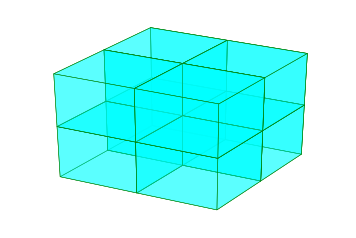

In [2]:
### Simulation time
ti, tf = 0.0, 5e-3
tstep = 1e-4
t = arange(0.0, tf, tstep)

### Geometrical arrangement of all the compartments
### a:n   = a, a+1, a+2,...,n-1
### a:n:i = a, a+i, a+2*i,..., until (n-1)
modelInput = '''[0:2:2, 0:20:4, 0:2:3]
                [38:40:2, 0:20:4, 0:2:3]
                [0:40:5, 0:20:5, 7:10:3]
                [0:40:4, 0:20:5, 5:7:2]
                [0:40:2, 0:20:4, 3:5:2]
                [2:38:2, 0:20:2, 2:3]
                [2:38, 0:20, 0:2]
                '''

#modelInput = '''[0:3,0,0:3]
#                [0:3,1:3,0]
#                [0,1:3,0:3]
#                [1:2:2,1:2:2,1:2:2]'''

modelInput = "[0:2,0:2,0:2]"

### MFB bounding box
bb = [2, 2, 2]
boundingBox = "[0:" + str(bb[0]) + ",0:" + str(bb[1]) + ",0:" + str(bb[2]) + "]"

### Get all the compartments as
### {'i-j-k': [i,j,k,lenth,width,height]}
cmpts = compartments(modelInput)
#for k in sorted(cmpts.iterkeys()): print "%s: %s" % (k, cmpts[k])

### Check if no compartment have overlapping volumes and
### there are no gaps in the model
print "cheching geometry"
if checkGeometry(boundingBox, cmpts):
    print 'Go ahead! All good with the geometry. Take a look at it yourself'
    plotCompartments(cmpts, bb)

In [3]:
print 'number of compartments:', len(cmpts)
### List of model objects for each compartment
cModels = []
for cname, cdim in [[k, cmpts[k]] for k in sorted(cmpts.iterkeys())]: # sorted by name
    cModels.append(mfb({'Ca':[], 'PMCA': [], 'calbindin': []},
                  name = cname,
                  dim = cdim,
                  nbrs = getNeighbours({cname: cdim}, cmpts))
                 )

c0 = '0-0-0'### Check if no compartment have overlapping volumes and
### there are no gaps in the model
#if checkGeometry(boundingBox, cmpts):
#    exit()
    
cModels[0] = mfb({'Ca':[], 'HH':[]},
                 name = c0,
                 dim = cmpts[c0],
                 nbrs = getNeighbours({c0: cmpts[c0]}, cmpts))

### print model details
#for cm in cModels: print cm.name, cm.dim, cm.nbrs, cm.nVar

### Make a list of initial index of each compartment
cmpi = initialIndex(cModels)

number of compartments: 8


In [4]:
### Putting all compartments together
def dXdt(X, t):
    dX = []
    j=0
    for cm in cModels:
        ## All compartments have V value of (0,0,0)th compartment
        cm.V = cModels[0].V

        ## Collect dX values from each compartment
        dX += cm.dXdt(X[j:j+cm.nVar], t)
        
        ## Calcium Flux
        caFlux = 0
        flux = 1e4
        for nbr in cm.nbrs:
            caFlux += flux*(X[cmpi[nbr]] - X[j]) #ADΔ(Ca)/Δx

        dX[j] += caFlux

        j += cm.nVar # increment counter to 1st element of next compartment

    return dX

In [5]:
### initial values
X0 = []
for cm in cModels:
    X0 += cm.X0
#print 'X0:', X0
print 'Total number of equations:', len(X0)

### Solve ODE
ti = time.time()
sol = odeint(dXdt, X0, t).T
tf = time.time()
print '\nDONE! | Time elapsed: ', tf-ti

Total number of equations: 96

DONE! | Time elapsed:  2.60130596161


In [6]:
for cname, idx in cmpi.items():
    for mname, m in result.data[cname].items():
        for vname, v in m.items():
            result.data[cname][mname][vname] = sol[idx+v]
    

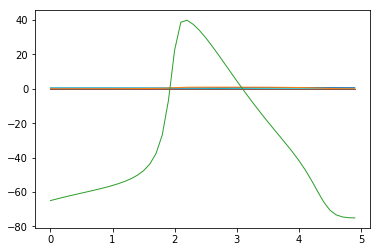

In [7]:
### Plot all results
fig, ax = subplots()
for cname, c in result.data.items():
    for mname, m in c.items():
        for vname, v in m.items():
            plot(t*1e3, v, lw=1, label=v)

show()

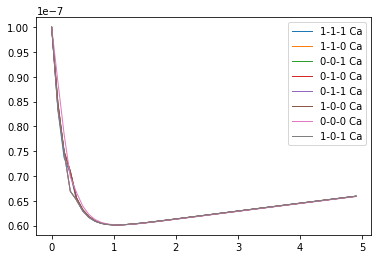

In [8]:
### Plot Ca 
fig, ax = subplots()
for cname, c in result.data.items():
    for vname, v in c['Ca'].items():
        plot(t*1e3, v, lw=1, label=cname+' '+vname)

legend()
show()